In [2]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.merge import merge
import ipywidgets
from ipywidgets import interact
import IPython

In [3]:
dataset = "test"
model_nr = 5

In [4]:
if dataset == "test":
    input_year = 2015
    target_year = 2020
else:
    input_year = 2010
    target_year = 2015

satellite_input = torch.load(f'../data/processed_transition/biomass/amazonia/250m/mosaic_{input_year}.pt')
biomass_input = torch.load(f'../data/processed_transition/biomass/amazonia/250m/biomass_{input_year}.pt')
transition_1_year= torch.load(f'../data/processed_transition/biomass/amazonia/250m/transition_{input_year-1}_{input_year}.pt')
transition_5_year = torch.load(f'../data/processed_transition/biomass/amazonia/250m/transition_{input_year-5}_{input_year}.pt')
transition_10_year = torch.load(f'../data/processed_transition/biomass/amazonia/250m/transition_{input_year-10}_{input_year}.pt')

satellite_target = torch.load(f'../data/processed_transition/biomass/amazonia/250m/mosaic_{target_year}.pt')
biomass_target = torch.load(f'../data/processed_transition/biomass/amazonia/250m/biomass_{target_year}.pt')
transition_target = torch.load(f'../data/processed_transition/biomass/amazonia/250m/transition_{target_year-5}_{target_year}.pt')

data = torch.load(f'../data/processed_transition/{dataset}_data.pt')
predictions = torch.load(f'../lightning_logs/version_{model_nr}/{dataset}_predictions.pt')

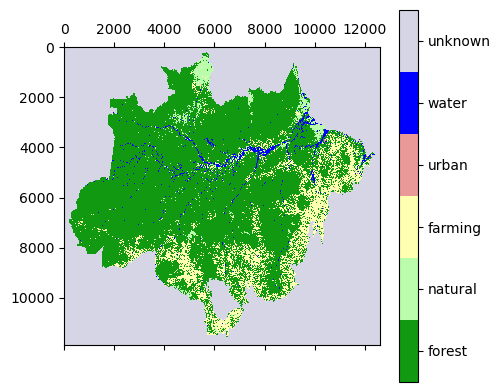

In [7]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(biomass_input,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

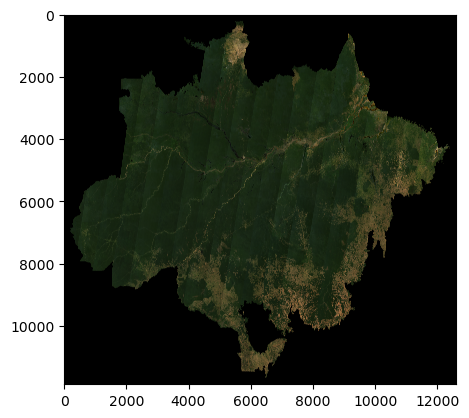

In [8]:
plt.imshow(satellite_input[:,:,[2,1,0]])
plt.show()

In [17]:
def compute_layers(input_px, output_px, data, predictions, transition_target):
    i = int(input_px/2)
    o = int(output_px/2)

    targets = []
    for point in data:
        x = point[0]
        y = point[1]
        target = torch.sum(transition_target[y-o:y+o, x-o:x+o])/(output_px**2)
        targets.append(target)
    targets = torch.tensor(targets)

    # x_point, y_point, x_cluster, y_cluster, target_class | target | prediction
    data_frame = torch.column_stack([data, targets, predictions])

    target_layer = np.ones(transition_target.shape) * -1
    prediction_layer = np.ones(transition_target.shape) * -1
    for point in data_frame:
        x = int(point[0])
        y = int(point[1])
        target_layer[y-o:y+o, x-o:x+o] = point[-2]
        prediction_layer[y-o:y+o, x-o:x+o] = point[-1]
    
    return target_layer, prediction_layer

In [66]:
def plot_input_output(input_px, output_px, data, target_layer, prediction_layer, nr_bin=0, random_choice=0, vmax=0.3):
    i = int(input_px/2)
    o = int(output_px/2)
    cmap_bio = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
    cmap_target = mpl.colormaps['viridis']
    cmap_target.set_under('white')

    point = data[torch.where(data[:,-1] == nr_bin)][random_choice]

    x = point[0]
    y = point[1]

    # fill up target layer
    xv = np.arange(x-i, x+i+o, output_px)
    yv = np.arange(y-i, y+i+o, output_px)
    xv, yv = np.meshgrid(xv, yv)
    data_points = np.vstack([xv.flatten(), yv.flatten()]).T
    for pointi in data_points:
        xi = int(pointi[0])
        yi = int(pointi[1])
        target_window = transition_target[yi-o:yi+o,xi-o:xi+o]
        target = torch.sum(target_window)/(output_px**2)
        target_layer[yi-o:yi+o, xi-o:xi+o] = target

    fig, axs = plt.subplots(3,5,figsize=(12,7))

    # input fields
    axs[0,0].imshow(satellite_input[y-i:y+i,x-i:x+i,[2,1,0]])
    axs[0,0].title.set_text(f'Satellite {input_year}')

    axs[1,0].imshow(biomass_input[y-i:y+i,x-i:x+i],cmap=cmap_bio,vmin = -.5, vmax = 5.5, interpolation='nearest')
    axs[1,0].title.set_text(f'Biomass {input_year}')

    axs[0,1].imshow(transition_1_year[y-i:y+i,x-i:x+i])
    axs[0,1].title.set_text(f'Loss {input_year-1}-{input_year}')

    axs[1,1].imshow(transition_5_year[y-i:y+i,x-i:x+i])
    axs[1,1].title.set_text(f'Loss {input_year-5}-{input_year}')

    axs[2,1].imshow(transition_10_year[y-i:y+i,x-i:x+i])
    axs[2,1].title.set_text(f'Loss {input_year-10}-{input_year}')

    # output fields
    axs[0,2].imshow(satellite_target[y-i:y+i,x-i:x+i,[2,1,0]])
    axs[0,2].title.set_text(f'Satellite {target_year}')

    axs[1,2].imshow(biomass_target[y-i:y+i,x-i:x+i],cmap=cmap_bio,vmin = -.5, vmax = 5.5, interpolation='nearest')
    axs[1,2].title.set_text(f'Biomass {target_year}')

    axs[0,3].imshow(target_layer[y-i:y+i,x-i:x+i], vmin = 0, vmax =vmax, cmap=cmap_target, interpolation='nearest')
    axs[0,3].add_patch(mpl.patches.Rectangle((i-o-0.5, i-o-0.5), output_px, output_px, fill=False, edgecolor='red'))
    axs[0,3].title.set_text('Target 5 years')

    axs[1,3].imshow(transition_target[y-i:y+i,x-i:x+i])
    axs[1,3].title.set_text(f'Loss {target_year-5}-{target_year}')

    axs[0,4].imshow(prediction_layer[y-i:y+i,x-i:x+i], vmin = 0, vmax =vmax, cmap=cmap_target, interpolation='nearest')
    axs[0,4].add_patch(mpl.patches.Rectangle((i-o-0.5, i-o-0.5), output_px, output_px, fill=False, edgecolor='red'))
    axs[0,4].add_patch(mpl.patches.Rectangle((0, 0), input_px-1, input_px-1, fill=False, edgecolor='lightgrey'))
    axs[0,4].title.set_text('Prediction 5 years')

    axs = axs.flatten()
    for ax in axs:
        # turn off axis
        ax.axis('off')
    plt.show()

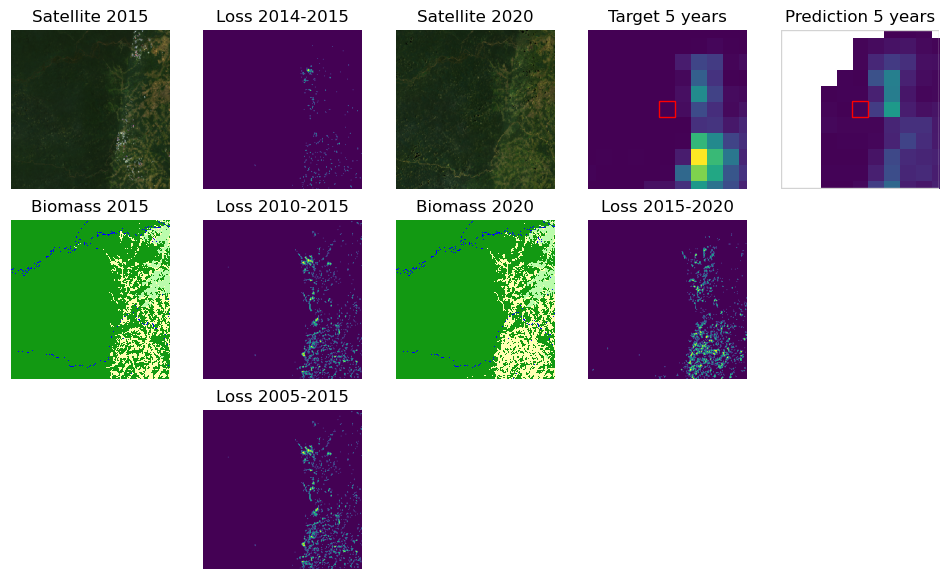

In [65]:
input_px = 400
output_px = 40

nr_bin = torch.max(data[:,-1]) - 5
points = data[torch.where(data[:,-1] == nr_bin)]
random_choice = np.random.choice(np.arange(len(points)))

target_layer, prediction_layer = compute_layers(input_px, output_px, data, predictions, transition_target)
plot_input_output(input_px, output_px, data, target_layer, prediction_layer, random_choice=random_choice)

In [69]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

nr_bin_widget = widgets.IntSlider(min=0, max=torch.max(data[:,-1]), step=1, value=torch.max(data[:,-1]))
random_choice_widget = widgets.IntSlider(min=0, max=len(data[torch.where(data[:,-1] == torch.max(data[:,-1]))])-1, step=1, value=0)
def update_choice_range(*args):
    random_choice_widget.max = len(data[torch.where(data[:,-1] == nr_bin_widget.value)])-1
random_choice_widget.observe(update_choice_range, 'value')

output_px_widget = widgets.IntSlider(min=0, max=100, step=4, value=40)
input_px_widget = widgets.IntSlider(min=0, max=2500, step=80, value=400)
def update_input_step(*args):
    input_px_widget.step = 2*output_px_widget.value
output_px_widget.observe(update_input_step, 'value')

interact(plot_input_output, 
            input_px=input_px_widget,
            output_px=output_px_widget,
            data=fixed(data),
            target_layer=fixed(target_layer),
            prediction_layer=fixed(prediction_layer),
            nr_bin=nr_bin_widget,
            random_choice=random_choice_widget,
            vmax=widgets.FloatSlider(min=0, max=1, step=0.1, value=0.3))

interactive(children=(IntSlider(value=400, description='input_px', max=2500, step=80), IntSlider(value=40, des…

<function __main__.plot_input_output(input_px, output_px, data, target_layer, prediction_layer, nr_bin=0, random_choice=0, vmax=0.3)>